The goal of this notebook is to show that the temporal aspect can be leveraged in a better way. 
Specifically, we want to show that if we consider two opposite causal directions, when we start conditioning on markov blanket members, one of the two directions mutual information will start to decrease, while the other one will keep stable (if not increase). 

In [1]:
N_VARS = 5
MAXLAGS = 3
N_JOBS = 40

In [2]:
import networkx as nx
from d2c.data_generation.utils import show_DAG
from d2c.descriptors import D2C, DataLoader

In [3]:
tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=MAXLAGS, 
                              n_variables=N_VARS, 
                              time_series_per_process=40, 
                              processes_to_use=[1,], 
                              noise_std=0.1, 
                              max_neighborhood_size=2, 
                              seed=42, 
                              max_attempts=10,
                              verbose=True)

tsbuilder.build()
dataloader = DataLoader(n_variables = N_VARS,
                    maxlags = MAXLAGS)
dataloader.from_tsbuilder(tsbuilder)

In [4]:
original_observations = dataloader.get_original_observations()
lagged_flattened_observations = dataloader.get_observations()
flattened_dags = dataloader.get_dags()

Let's consider the first DAG

In [5]:
one_obs = original_observations[0]
one_lagged_obs = lagged_flattened_observations[0]
one_dag = flattened_dags[0]

In [6]:
def return_mb(dag, variable_name):
    parents = list(dag.predecessors(variable_name))
    children = list(dag.successors(variable_name))
    spouses = [list(dag.predecessors(child)) for child in children]
    spouses = [item for sublist in spouses for item in sublist]
    mb = set(parents + children + spouses)
    if variable_name in mb:
        mb.remove(variable_name)
    return list(mb)


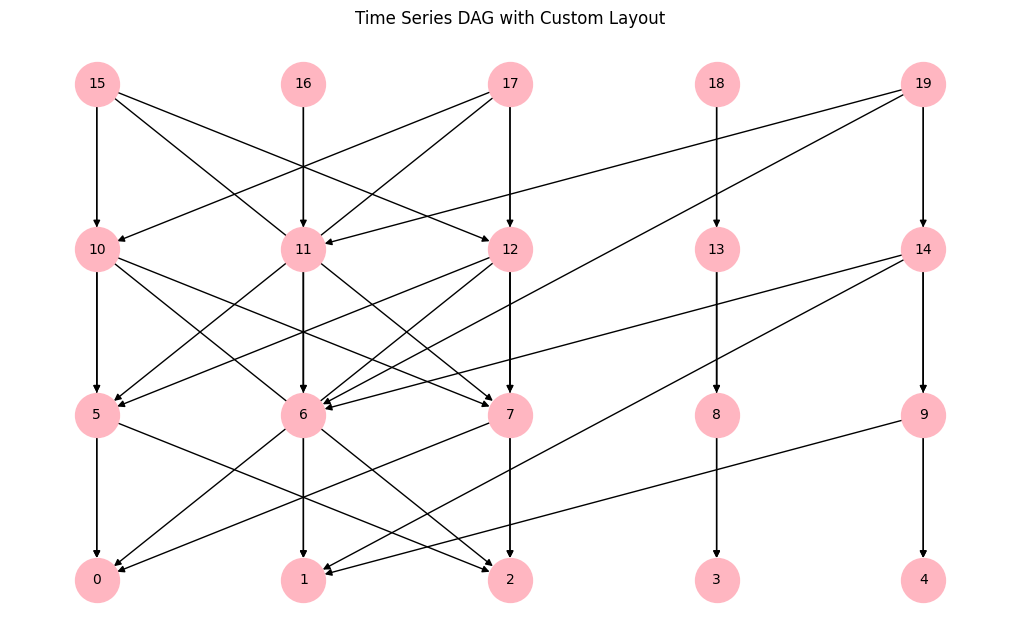

In [7]:
show_DAG(one_dag, N_VARS, MAXLAGS)

Let's consider on the first two variables and in particular on the causal relationship between variable 0 and variable 1. <br> 
We can see from the DAG that 1 --> 0 but 0 -/->1. Now if we focus specifically on lagged couples 11 --> 5 and 10 -/->6, we should be able to show the following: <br>

$I(11,5 | x)$ will not decrease by increasing the conditioning set <br>
$I(10,6 | x)$ will decrease by increasing the conditioning set <br>


In [8]:
# we won't compute the full descriptors set but we still need the estimators for Mutual Information
from d2c.descriptors.estimators import MutualInformationEstimator
mutual_information_estimator = MutualInformationEstimator() # default: estimator using Ridge


In [9]:
# ! git clone https://github.com/omesner/knncmi.git
# ! cd knncmi && pip install .
# ! cd ..
# ! rm -rf knncmi

In [10]:
MAXLAGS

3

In [11]:
verbose = False 
for edge in one_dag.edges:
    source, target = edge
    if (source - target) % N_VARS == 0:
        continue # parent -> child of the same variable 

    opposite_source = target + N_VARS
    opposite_target = source - N_VARS

    if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS+1):
        continue

    if verbose: print(f"Edge {source} -> {target}")


    # I(source, target | x)
    mb_source = return_mb(one_dag, source)
    if verbose: print(f'MB Souce {mb_source}')
    mb_target = return_mb(one_dag, target)
    if verbose: print(f'MB Target {mb_target}')

    combined_mbs = list(set(mb_source + mb_target) - {source, target})
    mutual_information_causal = {}
    for m_idx in range(1,len(combined_mbs)+1):
        m = combined_mbs[:m_idx]
        if verbose: print(f'Conditioning on {m}')
        single_mi = mutual_information_estimator.estimate_knn_cmi(one_lagged_obs, source, target, m)
        mutual_information_causal[m_idx] = single_mi


    if verbose: print(f"Opposite edge {opposite_source} -> {opposite_target}")

    # I(opposite_source, opposite_target | x)
    mb_opposite_source = return_mb(one_dag, opposite_source)
    if verbose: print(f'MB Souce {mb_opposite_source}')
    mb_opposite_target = return_mb(one_dag, opposite_target)
    if verbose: print(f'MB Target {mb_opposite_target}')

    opposite_combined_mbs = list(set(mb_opposite_source + mb_opposite_target) - {opposite_source, opposite_target})

    mutual_information_noncausal = {}
    for m_idx in range(1,len(opposite_combined_mbs)+1):
        m = opposite_combined_mbs[:m_idx]
        if verbose: print(f'Conditioning on {m}')
        single_mi = mutual_information_estimator.estimate_knn_cmi(one_lagged_obs, opposite_source, opposite_target, m)
        mutual_information_noncausal[m_idx] = single_mi
    
    print("Causal")
    print(mutual_information_causal)
    print("Non-causal")
    print(mutual_information_noncausal)


Causal
{1: 0.08425593927908852, 2: 0.07475927707283686, 3: 0.03217052771846532, 4: 0.040484581775942705, 5: 0.04180767518619065, 6: 0.028647773911516253}
Non-causal
{1: 0.11496821398173808, 2: 0.06194252175945663, 3: 0.02566037124171779, 4: 0.04671080867982435, 5: 0.035476871322066714, 6: 0.026416319203663545}
Causal
{1: 0.001254939438296462, 2: 0.04543958515064977, 3: 0.07091350443806935, 4: 0.06455728689041779, 5: 0.04326106191574477, 6: 0.03432588256692219}
Non-causal
{1: 0.05588355938622846, 2: 0.03926521729813188, 3: 0, 4: 0.018747116086699316, 5: 0.043482256009170224, 6: 0.032235749358423}
Causal
{1: 0.11496821398173808, 2: 0.06194252175945663, 3: 0.02566037124171779, 4: 0.04671080867982435, 5: 0.035476871322066714, 6: 0.026416319203663545}
Non-causal
{1: 0.08425593927908852, 2: 0.07475927707283686, 3: 0.03217052771846532, 4: 0.040484581775942705, 5: 0.04180767518619065, 6: 0.028647773911516253}
Causal
{1: 0.08966766162685728, 2: 0.043630525775498474, 3: 0.05320323163416631, 4: 0

In [21]:
from tqdm import tqdm

# only the parent of the putative effect 
verbose = False 
deltas_causal = []
deltas_noncausal = []

for position_index in tqdm(range(len(original_observations)), total=len(original_observations)):
    one_obs = original_observations[position_index]
    one_lagged_obs = lagged_flattened_observations[position_index]
    
    for edge in one_dag.edges:
        source, target = edge
        if (source - target) % N_VARS == 0:
            continue # parent -> child of the same variable 

        opposite_source = target + N_VARS
        opposite_target = source - N_VARS

        if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS+1):
            continue

        if verbose: print(f"Edge {source} -> {target}")


        # I(source, target | x)
        parent_of_putative_effect = target + N_VARS 
        if parent_of_putative_effect >= N_VARS * (MAXLAGS+1):
            continue
        before_causal = mutual_information_estimator.estimate_knn_cmi(one_lagged_obs, source, target)
        after_causal = mutual_information_estimator.estimate_knn_cmi(one_lagged_obs, source, target, [parent_of_putative_effect])
        delta_causal = abs(before_causal - after_causal)

        deltas_causal.append(delta_causal)

        if verbose: print(f"Opposite edge {opposite_source} -> {opposite_target}")

        # I(opposite_source, opposite_target | x)
        parent_of_putative_effect = opposite_target + N_VARS 
        if parent_of_putative_effect >= N_VARS * (MAXLAGS+1):
            continue
        before_noncausal = mutual_information_estimator.estimate_knn_cmi(one_lagged_obs, opposite_source, opposite_target)
        after_noncausal = mutual_information_estimator.estimate_knn_cmi(one_lagged_obs, opposite_source, opposite_target, [parent_of_putative_effect])
        delta_noncausal = abs(before_noncausal - after_noncausal)

        deltas_noncausal.append(delta_noncausal)



100%|██████████| 80/80 [01:46<00:00,  1.33s/it]


In [17]:
deltas_causal

[0.05447379433160468,
 0.07375608494227338,
 0.0014103131720480389,
 0.08096721191022749,
 0.06799701829771956,
 0.007499431358022106,
 0.04463500934260088,
 0.07457533614770545,
 0.0049312142476442555,
 0.0845227998916741,
 0.07721413349550463,
 0.0012653939369568004,
 0.03573007803329109,
 0.005149344902753025,
 0.06594480563745266]

TypeError: unhashable type: 'numpy.ndarray'

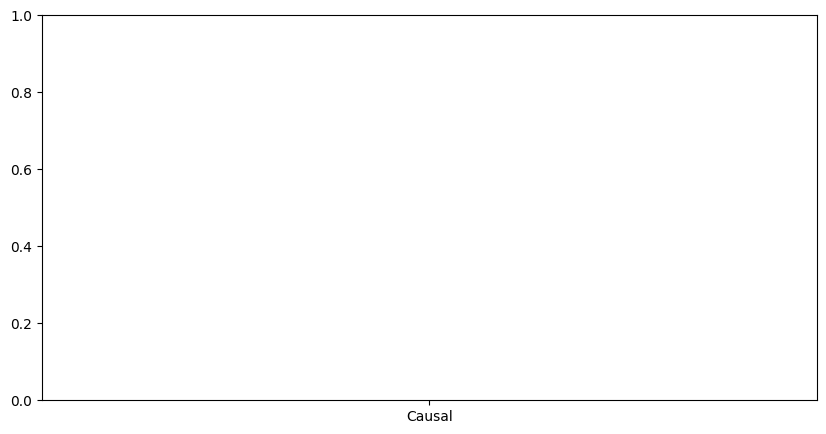

In [18]:
#boxplot deltas causal vs noncausal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 5))
sns.boxplot(x=['Causal', 'Non-causal'], y=[np.array(deltas_causal), np.array(deltas_noncausal)])
plt.ylabel('Delta MI')
plt.show()


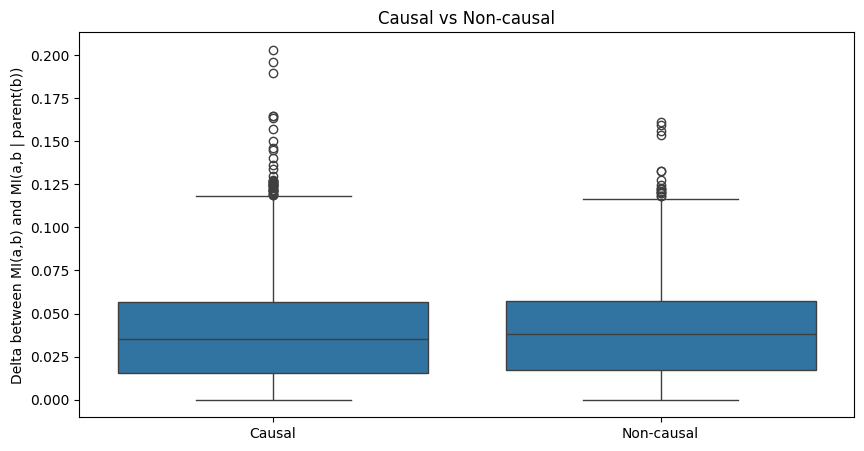

In [23]:
# Combine the data into a single list or array
all_deltas = deltas_causal + deltas_noncausal
labels = ['Causal'] * len(deltas_causal) + ['Non-causal'] * len(deltas_noncausal)

# Create boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=labels, y=all_deltas)
plt.ylabel('Delta between MI(a,b) and MI(a,b | parent(b))')
plt.title('Distribution of deltas between MI(a,b) and MI(a,b | parent(b)) for 80 different dags ')
plt.show()